# Information retrieval for movies recommendation

Database which the project it's based on:   
[HBO Max](https://www.kaggle.com/datasets/dgoenrique/hbo-max-movies-and-tv-shows)  

<div></div> 

In [56]:
import numpy as np 
import pandas as pd
from toolbox import preprocessing
import ast
from sklearn.metrics.pairwise import cosine_similarity

In [57]:

# # Calculate cosine similarity between query vector and document vectors
# similarities = cosine_similarity(query_vector.reshape(1, -1), document_vectors)

# # Get the indices of the most similar documents
# most_similar_indices = similarities.argsort()[0][::-1]

# # Retrieve the most similar documents
# most_similar_documents = [corpus[i] for i in most_similar_indices]


<div></div> 

## Leitura dos Arquivos

As bases vieram em formato CSV, portanto, só foi utilizado o pandas para leitura e feito um concat

<div></div> 

In [58]:
# load
try: 
    pop_movies = pd.read_csv('../data/modified/popular_movies.csv.zip')['tmdbId']
except: 
# Load the "rating" and "link" with the id from multiple sources
    ratings = pd.read_csv('../data/origin/ratings.zip')
    links = pd.read_csv('../data/origin/links.zip')

    # Inner join between both files
    ratings = ratings.merge(links, how='inner', on='movieId')

    # Select only the movies with at least 750 reviews, to classify as popular enough for recommendation
    pop_movies = ratings['movieId'].value_counts().to_frame().query('count > 250').index
    pop_movies = links.query('movieId in @pop_movies')['tmdbId'].dropna()

    pop_movies.to_csv('../data/modified/popular_movies.csv.zip', index=False, compression='zip')

    del ratings, links

In [59]:
# Load the 'credits' dataset from a zipped CSV file
dt_c = pd.read_csv('../data/origin/credits.zip')

# Load the 'movies_metadata' dataset from a zipped CSV file
dt_m = pd.read_csv('../data/origin/movies_metadata.zip')

# Convert the 'id' column to numeric data type, ignoring any errors
dt_m['id'] = pd.to_numeric(dt_m['id'], errors='coerce')

# Convert the 'popularity' column to numeric data type, ignoring any errors
dt_m['popularity'] = pd.to_numeric(dt_m['popularity'], errors='coerce')

# Merge the 'movies_metadata' DataFrame with the 'credits' DataFrame based on the 'id' column
dt_m = dt_m.merge(dt_c.set_index('id'), how='left', left_on=['id'], right_index=True)

# Drop rows with missing values in the 'id' column
dt_m.dropna(subset=['id', 'overview'], inplace=True)

# Select the movies with the minimun engagement
dt_m.query('id in @pop_movies', inplace=True)

# Reset index 
dt_m.reset_index(drop=True, inplace=True)

# Delete the 'credits' DataFrame to free up memory
del dt_c

dt_m.drop_duplicates(subset=['imdb_id'], inplace=True, ignore_index=True)

C:\Users\kevin\AppData\Local\Temp\ipykernel_5400\2466252914.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dt_m = pd.read_csv('../data/origin/movies_metadata.zip')


In [60]:
# Define the variables
v = 'vote_count'  # Vote count column
m = 'vote_count.quantile(0.85)'  # Quantile of vote count
R = 'vote_average'  # Vote average column
C = 'vote_average.mean()'  # Mean of vote average

# Evaluate the score using the defined variables and assign it to a new column 'score'
dt_m.eval(f'score = ({v}/({v}+{m}) * {R}) + ({m}/({m}+{v}) * {C})', inplace=True)

del v, m, R, C

<div></div> 

## Pré-Processamento 

<div></div> 


In [61]:
# Create a new column 'p_cast' containing the names of the first five cast members in lower case with underscores instead of spaces
dt_m['p_cast'] = dt_m['cast'].map(lambda cast: [x.get('name').lower().replace(' ', '_') for x in ast.literal_eval(cast)[0:5]])

# Define a function to extract the name of the director from the crew data
def get_director(string):
    crew = ast.literal_eval(string)
    for i in crew:
        if i.get('job').lower() == 'director':
            return i.get('name').lower().replace(' ', '_')

# Create a new column 'director' containing the name of the director for each row
dt_m['director'] = dt_m['crew'].map(get_director)

# Create a new column 'p_director' containing a list with the director's name
dt_m['p_director'] = dt_m['director'].map(lambda dir: [dir])

# Create a new column 'p_genres' containing the names of the genres in lower case with underscores instead of spaces
dt_m['p_genres'] = dt_m['genres'].map(lambda genres: [genre.get('name').lower().replace(' ', '_') for genre in ast.literal_eval(genres)])

# Create a new column 'docs' by concatenating the 'p_cast', 'p_genres', and 'p_director' lists
dt_m.eval('metadata = p_cast + p_genres + p_director', inplace=True)


### Remoção de palavras e transformação de minúsculos

In [62]:
# Removing special characters and numbers from the 'overview' column
dt_m['p_overview'] = dt_m['overview'].replace(r'([^\w\s]|\d+)', ' ', regex=True)
# Applying lowercase and strip simultaneously to the 'p_overview' column
dt_m['p_overview'] = dt_m['p_overview'].apply(lambda x: x.lower().strip() if isinstance(x, str) else x)
# Extracting lowercase genre names from the 'genres' column and replacing spaces with underscores
dt_m['p_genres'] = dt_m['genres'].map(lambda genres: [genre.get('name').lower().replace(' ', '_') for genre in ast.literal_eval(genres)])

# Removing stopwords from the 'p_overview' column
dt_m['p_overview'] = dt_m['p_overview'].map(preprocessing.remove_stopwords)
# Lemmatizing the text in the 'p_overview' column
dt_m['p_overview'] = dt_m['p_overview'].map(preprocessing.lemmatize_text)
# Tokenizing the words in the 'p_overview' column
dt_m['p_overview'] = dt_m['p_overview'].map(preprocessing.word_tokenize)

# Filtering out rows where 'p_overview' has a length greater than 0
dt_m.query('p_overview.str.len() > 0', inplace=True)
# Checking the shape of the DataFrame after filtering rows where 'p_genres' has a length greater than 0
dt_m.query('p_genres.str.len() > 0', inplace=True)

# Resetting the index of the DataFrame to ensure it starts from 0
dt_m.reset_index(drop=True, inplace=True)


### TF-IDF from Corpus

In [94]:
from gensim import corpora, models
import numpy as np
import pandas as pd

def filter_words_by_tfidf(data, threshold=0.04):
    # Create a dictionary based on the data
    dictionary = corpora.Dictionary(data)

    # Convert the data into Bag of Words (BoW) representation
    bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in data]

    # Create a TF-IDF model based on the BoW corpus
    tfidf = models.TfidfModel(bow_corpus, smartirs='nfc')

    # Identify words to remove based on their TF-IDF weight
    words_to_remove = set()
    for doc in tfidf[bow_corpus]:
        for id, freq in doc:
            if np.around(freq, decimals=3) <= threshold:
                words_to_remove.add(dictionary[id])

    # Filter out the words to be removed from the data
    filtered_data = [[word for word in doc if word not in words_to_remove] for doc in data]

    return filtered_data

# Example usage
data = dt_m['p_overview'].to_list()
filtered_data = filter_words_by_tfidf(data)

# Update 'p_overview' column in dt_m with the filtered data
dt_m['p_overview'] = filtered_data

In [63]:
# from gensim import corpora
# from gensim import models
# import numpy as np

# data = dt_m['p_overview'].to_list()

# # Create a dictionary based on the 'p_overview' data
# dictionary = corpora.Dictionary(data)

# # Convert the data into Bag of Words (BoW) representation
# bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in data]

# # Word weight in Bag of Words corpus
# word_weight = []

# # Iterate over each document in the BoW corpus
# for doc in bow_corpus:
#     # Extract the word ID and frequency for each word in the document
#     for id, freq in doc:
#         word_weight.append([dictionary[id], freq])

# # Create a TF-IDF model based on the BoW corpus
# tfIdf = models.TfidfModel(bow_corpus, smartirs='nfc')

# # TF-IDF Word Weight
# weight_tfidf = []
# # Iterate over each document in the TF-IDF representation
# for doc in tfIdf[bow_corpus]:
#     # Extract the word ID and TF-IDF weight for each word in the document
#     for id, freq in doc:
#         weight_tfidf.append([dictionary[id], np.around(freq, decimals=3)])

# # Identify words to remove based on their TF-IDF weight
# remove = pd.Series([x[0] for x in weight_tfidf if x[1] <= 0.04]).unique()
# remove = set(remove)

# # Filter out the words to be removed from the 'p_overview' column of dt_m
# dt_m['p_overview'] = dt_m['p_overview'].map(lambda words: [x for x in words if x not in remove])


# Using a Model for Information Retrieval

## Model for Overview

In [64]:
from gensim.models import KeyedVectors, Word2Vec

In [65]:

# Load pre-trained word vectors using Word2Vec format
model_ov = KeyedVectors.load_word2vec_format('../models/numberbatch-en.txt')

# Create a set of vocabulary words from the loaded model
index_set = set(model_ov.index_to_key)

# Filter out words in 'p_overview' that are not present in the vocabulary set
dt_m['p_overview'] = dt_m['p_overview'].map(lambda words: [w for w in words if w in index_set])


In [66]:

# query = dt_m['p_overview'][0]

# query_vector = sum(model[word] for word in query) / len(query)

# dt_m['embed_docs'] = dt_m['p_overview'].map(lambda doc: sum(model[word] for word in doc) / len(doc))

# similarities = dt_m['embed_docs'].map(lambda doc: cosine_similarity(query_vector.reshape(1, -1) , doc.reshape(1, -1))).sort_values(ascending=False)[:100]

# sim = {i: v[0][0] for i, v in zip(similarities.index, similarities.values)}

# dt_m.iloc[list(sim.keys()),:].sort_values(by=['score', 'popularity'], ascending=False)[:10]

## Model for Metadata

In [67]:
model_md = Word2Vec.load('../models/metadata_model.txt')
model_md = model_md.wv

## Filter necessary columns

In [68]:
dt_m.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'score', 'p_cast',
       'director', 'p_director', 'p_genres', 'metadata', 'p_overview'],
      dtype='object')

In [69]:
dt_m = dt_m.filter(['title', 'popularity', 'id', 'score', 'p_overview', 'metadata', 'p_genres'])

## Apply models

In [70]:
dt_m['metadata'] = dt_m['metadata'].map(lambda meta: [word for word in meta if word is not None])
# Filter out words in 'p_overview' that are not present in the vocabulary set
dt_m['p_overview'] = dt_m['p_overview'].map(lambda words: [w for w in words if w in index_set])

In [71]:
dt_m['embed_meta'] = dt_m['metadata'].map(lambda embed: sum(model_md[(word)] for word in list(embed)) / len(embed))
dt_m['embed_over'] = dt_m['p_overview'].map(lambda embed: sum(model_ov[(word)] for word in list(embed)) / len(embed))

In [72]:
# sim_md = dt_m['embed_meta'].map(lambda meta: cosine_similarity(dt_m.query('title=="Toy Story"')['embed_meta'][0].reshape(1, -1), meta.reshape(1, -1)))
# sim_ov = dt_m['embed_over'].map(lambda meta: cosine_similarity(dt_m.query('title=="Toy Story"')['embed_over'][0].reshape(1, -1), meta.reshape(1, -1)))

# a = {i: j[0][0] for i, j in zip(sim_md.index, sim_md.values)}
# b = {i: j[0][0] for i, j in zip(sim_ov.index, sim_ov.values)}

# similarity_matrix = pd.DataFrame({'sim_md': a.values(), 'sim_ov': b.values()}, index=a.keys())

# i = similarity_matrix.eval('rank = sim_md * sim_ov').sort_values(by=['rank'], ascending=False)[1:100].index

# dt_m.query('@i').sort_values(by='score', ascending=False)

In [114]:
def find_similar(title:str, model_ov=model_ov, model_md=model_md, database=dt_m, top_n=100): 
    
    movie_embed = database.query(f'title=="{title}"')

    md_embed = movie_embed['embed_meta'].values[0]
    ov_embed = movie_embed['embed_over'].values[0]

    sim_md = database['embed_meta'].map(lambda meta: cosine_similarity(md_embed.reshape(1, -1), meta.reshape(1, -1)))
    sim_ov = database['embed_over'].map(lambda meta: cosine_similarity(ov_embed.reshape(1, -1), meta.reshape(1, -1)))
    
    sim_md = {i: j[0][0] for i, j in zip(sim_md.index, sim_md.values)}
    sim_ov = {i: j[0][0] for i, j in zip(sim_ov.index, sim_ov.values)}

    similarity_matrix = pd.DataFrame({'sim_md': sim_md.values(), 'sim_ov': sim_ov.values()}, index=sim_md.keys())

    i = similarity_matrix.eval('rank = sim_md * sim_ov').sort_values(by=['rank'], ascending=False)[1:top_n+1].index

    results = database.query('@i')

    results.eval('n_pop = (popularity - popularity.mean())/popularity.std()', inplace=True)
    results.eval('n_scr = (score - score.min()) / (score.max() - score.min())', inplace=True)
    results.eval('scr = n_pop * n_scr', inplace=True)

    return results.sort_values('scr', ascending=False).filter(['title', 'id', 'popularity', 'score'])

In [115]:
find_similar('Toy Story').head(10)

,title,id,popularity,score
6928,Inside Out,150540.0,23.985587,7.707619
3426,"Monsters, Inc.",585.0,26.419962,7.349218
5421,Ratatouille,2062.0,20.508030,7.304573
5707,WALL·E,10681.0,16.088366,7.613720
6128,Toy Story 3,10193.0,16.966470,7.393455
2325,Toy Story 2,863.0,17.547693,7.122641
2226,Who Framed Roger Rabbit,856.0,16.785960,6.889856
1,Jumanji,8844.0,17.015539,6.764869
1475,Back to the Future Part II,165.0,13.689855,7.202305
6533,Wreck-It Ralph,82690.0,13.697597,6.981988


In [116]:
find_similar('Avengers: Age of Ultron').head(10)

,title,id,popularity,score
6873,Captain America: Civil War,271110.0,145.882135,7.020987
6357,The Avengers,24428.0,89.887648,7.324816
7103,Ghost in the Shell,315837.0,68.726676,6.057664
7087,Rogue One: A Star Wars Story,330459.0,36.567575,7.240460
6842,Maze Runner: The Scorch Trials,294254.0,41.225769,6.487180
6681,Thor: The Dark World,76338.0,34.905447,6.738627
6618,Pacific Rim,68726.0,33.949359,6.656282
6863,Mad Max: Fury Road,76341.0,29.361780,7.217745
6746,Lucy,240832.0,36.447603,6.321511
6747,X-Men: Days of Future Past,127585.0,26.058586,7.349323


In [117]:
find_similar('Dunkirk').head(10)

,title,id,popularity,score
6814,Fury,228150.0,36.713807,7.206293
1492,Saving Private Ryan,857.0,21.758054,7.658130
5888,Inglourious Basterds,16869.0,16.895640,7.704113
6802,American Sniper,190859.0,19.228561,7.225977
958,The Great Escape,5925.0,14.384114,7.009547
983,Ben-Hur,665.0,14.319743,6.859080
1080,The Last of the Mohicans,9361.0,15.228794,6.722226
2194,The Dirty Dozen,1654.0,15.640007,6.690934
2742,The Patriot,2024.0,15.960788,6.632221
968,Patton,11202.0,14.382289,6.653441


## Plot

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Example embeddings
embeddings = [list(x) for x in dt_m['embed_meta']]

# Perform dimensionality reduction using PCA
pca = PCA(n_components=30)
embeddings_pca = pca.fit_transform(embeddings)

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=3, n_jobs=-1)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

In [82]:
plot = pd.DataFrame({'title': dt_m['title'], 'genre': dt_m['p_genres'].map(lambda lista: lista[0]), 'tsnx': embeddings_tsne[:,0], 'tsny': embeddings_tsne[:,1]})
plot

,title,genre,tsnx,tsny
0,Toy Story,animation,-3.905166,97.117767
1,Jumanji,adventure,-23.390938,66.480530
2,Grumpier Old Men,romance,76.620712,-30.291721
3,Waiting to Exhale,comedy,2.088869,3.574719
4,Father of the Bride Part II,comedy,26.035267,45.991135
...,...,...,...,...
7104,Life,horror,-82.926880,-3.319196
7105,Alien: Covenant,horror,-81.193306,-1.536816
7106,Band of Brothers,action,-18.693848,-94.543304
7107,Baby Driver,action,-35.726952,9.226822


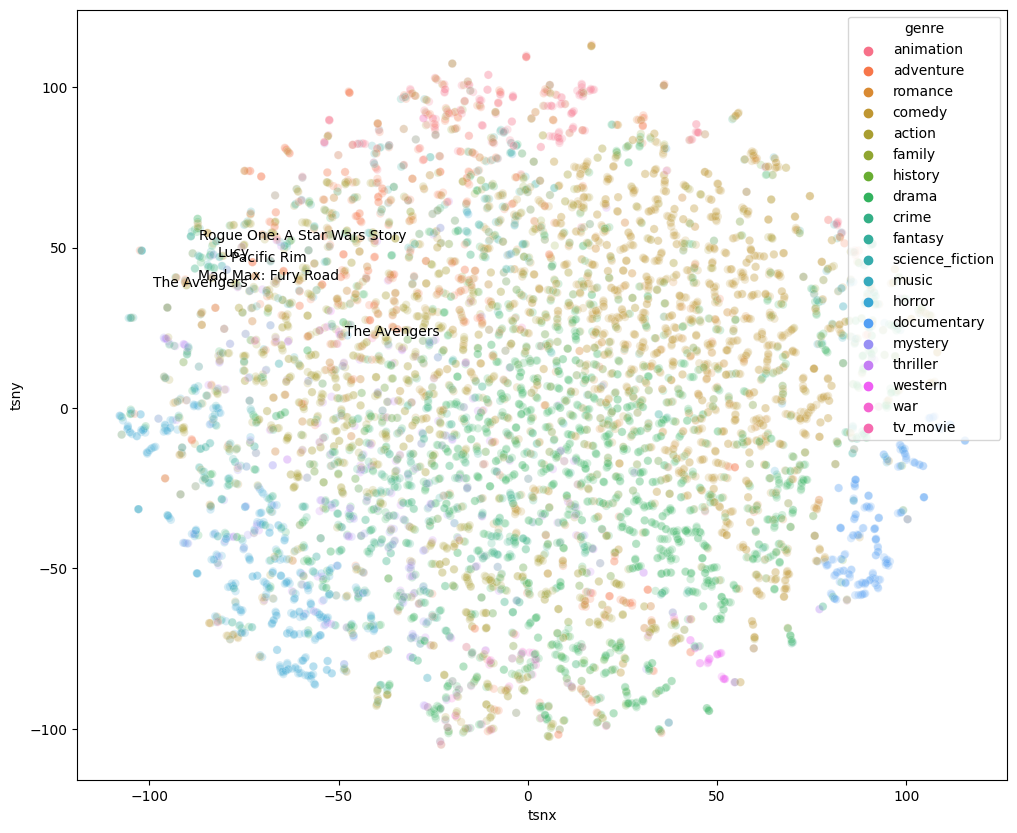

In [83]:
hero = ['The Avengers','Rogue One: A Star Wars Story','Pacific Rim','Mad Max: Fury Road','Lucy']

ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data=plot, x='tsnx', y='tsny', hue='genre', alpha=0.2)
for i, row in plot.query('title in @hero').iterrows(): 
    plt.annotate(row['title'], (row['tsnx'], row['tsny']), textcoords="offset points", xytext=(0,20), ha='center')


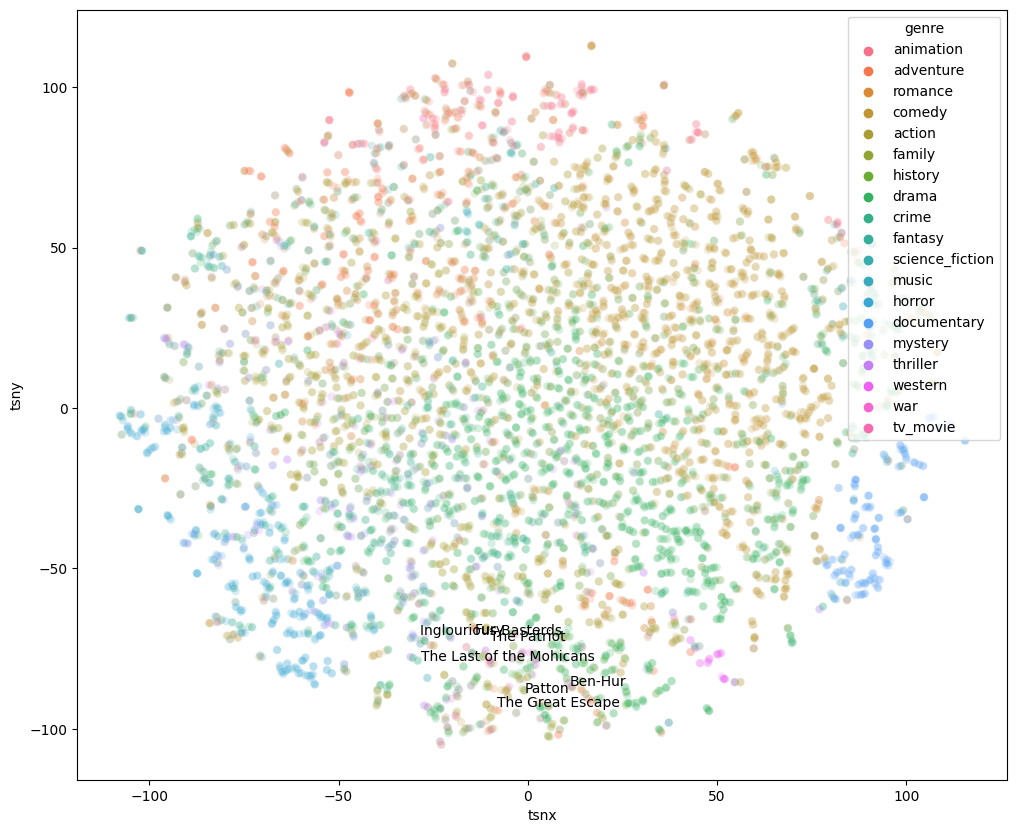

In [84]:

war = ['Fury','Inglourious Basterds',  'The Great Escape', 'Ben-Hur', 'The Last of the Mohicans', 'The Patriot', 'Patton']

ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data=plot, x='tsnx', y='tsny', hue='genre', alpha=0.2)
for i, row in plot.query('title in @war ').iterrows(): 
    plt.annotate(row['title'], (row['tsnx'], row['tsny']), textcoords="offset points", xytext=(0,20), ha='center')


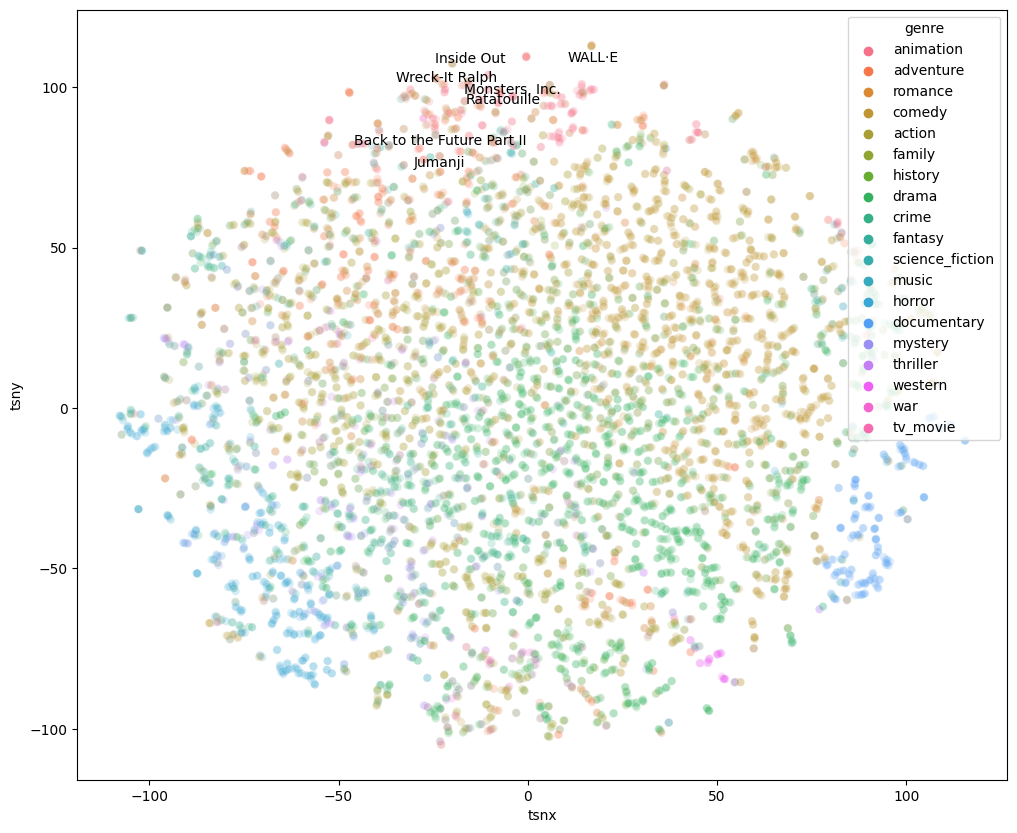

In [85]:
animation = ['Inside Out', 'Monsters, Inc.', 'Ratatouille', 'WALL·E', 'Jumanji', 'Back to the Future Part II', 'Wreck-It Ralph']


ax = plt.subplots(figsize=(12, 10))
sns.scatterplot(data=plot, x='tsnx', y='tsny', hue='genre', alpha=0.2)
for i, row in plot.query('title in @animation').iterrows(): 
    plt.annotate(row['title'], (row['tsnx'], row['tsny']), textcoords="offset points", xytext=(0,20), ha='center')


## User Feedback

In [52]:
links = pd.read_csv('../data/origin/links.zip')
links.head(2)

links = {i: j for i, j in zip(links['movieId'], links['tmdbId'])}

In [92]:
import surprise

ratings = pd.read_csv('../data/origin/ratings_small.zip')
ratings['movieId'] = ratings['movieId'].map(links)

ratings.dropna(inplace=True)
ratings['movieId'] = ratings['movieId'].astype(np.int32)
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,9909,2.5,1260759144
1,1,11360,3.0,1260759179


In [101]:
filter = dt_m['id'].values

In [103]:
ratings.query('movieId in @filter', inplace=True)

In [108]:
reader = surprise.Reader()
data = surprise.Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = surprise.SVD()

# Run 5-fold cross-validation and print results
surprise.model_selection.cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8978  0.8878  0.8936  0.8936  0.8910  0.8928  0.0033  
MAE (testset)     0.6892  0.6817  0.6858  0.6914  0.6878  0.6872  0.0033  
Fit time          0.88    0.96    0.95    1.20    0.96    0.99    0.11    
Test time         0.15    0.09    0.10    0.09    0.11    0.11    0.02    


{'test_rmse': array([0.89776838, 0.88781665, 0.8936343 , 0.89364121, 0.8910021 ]),
 'test_mae': array([0.68923586, 0.68168158, 0.68579777, 0.69140322, 0.68775037]),
 'fit_time': (0.8845446109771729,
  0.95908522605896,
  0.9539062976837158,
  1.2031455039978027,
  0.9566304683685303),
 'test_time': (0.15044713020324707,
  0.08837890625,
  0.10001349449157715,
  0.09343671798706055,
  0.10578036308288574)}

In [109]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [118]:
find_similar('Toy Story')

,title,id,popularity,score
6928,Inside Out,150540.0,23.985587,7.707619
3426,"Monsters, Inc.",585.0,26.419962,7.349218
5421,Ratatouille,2062.0,20.508030,7.304573
5707,WALL·E,10681.0,16.088366,7.613720
6128,Toy Story 3,10193.0,16.966470,7.393455
...,...,...,...,...
1200,Leave it to Beaver,37244.0,1.635911,6.424160
5334,"Snoopy, Come Home",15242.0,1.811747,6.446773
1481,Babes in Toyland,32611.0,1.365451,6.436814
1358,"Dancer, Texas Pop. 81",78373.0,0.567444,6.451404


In [129]:
svd.predict(1, 771)

Prediction(uid=1, iid=771, r_ui=None, est=2.3629508341415435, details={'was_impossible': False})

In [112]:
a = svd.predict(1, 302, 3)

In [184]:
def user_based(user_id:int, title:str, model_user=svd): 

    sim = find_similar(title)

    sim['est_rant'] = sim['id'].map(lambda id: model_user.predict(user_id, id).est)

    return sim.sort_values('est_rant', ascending=False).eval('rel = est_rant > 3.5')

In [185]:
user_based(1, 'Toy Story')

,title,id,popularity,score,est_rant,rel
6128,Toy Story 3,10193.0,16.966470,7.393455,3.354945,False
2090,Big,2280.0,9.562292,6.673217,3.167920,False
2325,Toy Story 2,863.0,17.547693,7.122641,3.126673,False
5421,Ratatouille,2062.0,20.508030,7.304573,3.052077,False
3426,"Monsters, Inc.",585.0,26.419962,7.349218,3.011257,False
...,...,...,...,...,...,...
2899,Rugrats in Paris: The Movie,16340.0,5.568359,6.407913,1.877544,False
1275,Home Alone 3,9714.0,8.042090,5.935036,1.825354,False
376,Coneheads,9612.0,10.722729,6.149018,1.719580,False
2031,Inspector Gadget,332.0,11.677244,5.935969,1.680260,False


In [180]:
ratings['userId'].value_counts()

userId
547    1892
564    1757
15     1627
624    1498
73     1497
       ... 
356      20
583      20
485      19
668      19
469      19
Name: count, Length: 671, dtype: int64

In [187]:
user_based(547, 'Batman')['rel'].value_counts()

rel
False    69
True     31
Name: count, dtype: int64

In [161]:
dt_m['title']

0                         Toy Story
1                           Jumanji
2                  Grumpier Old Men
3                 Waiting to Exhale
4       Father of the Bride Part II
                   ...             
7104                           Life
7105                Alien: Covenant
7106               Band of Brothers
7107                    Baby Driver
7108                        Dunkirk
Name: title, Length: 7109, dtype: object

In [141]:
a.sort_values('est_rant', ascending=False).eval('rel = est_rant > 2.5')['rel'].value_counts()

rel
True     56
False    44
Name: count, dtype: int64

## Metrics

In [187]:
recover = find_similar('Toy Story')

In [239]:
recover['title']

6928               Inside Out
3426           Monsters, Inc.
5421              Ratatouille
5707                   WALL·E
6128              Toy Story 3
                ...          
1200       Leave it to Beaver
5334        Snoopy, Come Home
1481         Babes in Toyland
1358    Dancer, Texas Pop. 81
504                Home Alone
Name: title, Length: 100, dtype: object

In [204]:
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import metrics

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


561.62775662962


In [210]:
plot

,title,genre,tsnx,tsny,category
0,Toy Story,animation,-3.367539,96.901932,0
1,Jumanji,adventure,-22.847515,67.301048,1
2,Grumpier Old Men,romance,77.084755,-30.124235,2
3,Waiting to Exhale,comedy,1.785374,3.412139,3
4,Father of the Bride Part II,comedy,25.670513,45.526344,3
...,...,...,...,...,...
7104,Life,horror,-83.373688,-3.510639,12
7105,Alien: Covenant,horror,-81.657257,-1.786415,12
7106,Band of Brothers,action,-18.491964,-94.686218,4
7107,Baby Driver,action,-35.277866,9.542352,4


In [234]:
X = plot[['tsnx', 'tsny']].to_numpy()
y = plot['category'].to_numpy()

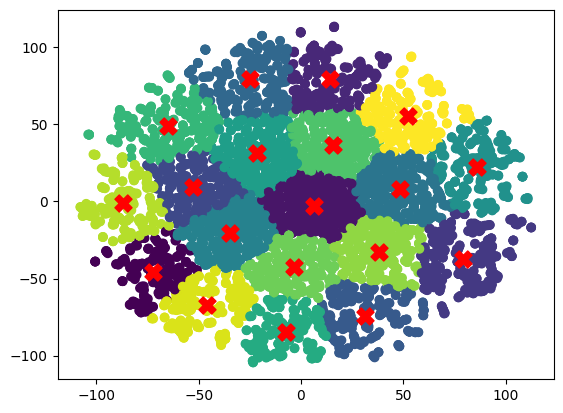

In [237]:
kmeans = KMeans(n_clusters=19, random_state=42, n_init='auto').fit(X)
labels = kmeans.labels_

centroids = kmeans.cluster_centers_

# Plotar os pontos de dados com cores diferentes para cada cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')

# Plotar os centroides dos clusters
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=150, color='red')

# Mostrar o gráfico
plt.show()

In [238]:
 
print(metrics.calinski_harabasz_score(X, labels))

5972.507658591657
